Import library 


In [1]:
from skimage.feature import hog
from skimage.io import imread
from sklearn.externals import joblib
import glob
import os
from sklearn.svm import LinearSVC
import numpy as np
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression
import imutils
import cv2
from skimage import color
import matplotlib.pyplot as plt 


Define config parameter

In [2]:
vehicles_path = 'Dataset/Train/vehicles'
non_vehicles_path = 'Dataset/Train/non_vehicles'
min_window_size = [64, 64]
step_size = [8, 8]
downscale = 1.25
orientations = 16
pixels_per_cell = [8, 8]
cells_per_block = [4, 4]
visualize = False
normalize = True
vehicles_feat_path = 'Dataset/features/vehicles'
non_vehicles_feat_path = 'Dataset/features/non_vehicles'
model_path = 'Dataset/models/svm.model'
threshold = .3
test_forder = 'Dataset/Test'

Define extract HOG features function


In [3]:


def extract_features(): 
    for im_path in glob.glob(os.path.join(vehicles_path, "*")):
        im = imread(im_path, as_grey=True)
        fd = hog(im, orientations, pixels_per_cell, cells_per_block, visualize, normalize)        
        fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(vehicles_feat_path, fd_name)
        joblib.dump(fd, fd_path)
    print ("vehicles features saved in {}".format(vehicles_feat_path))
    
    for im_path in glob.glob(os.path.join(non_vehicles_path, "*")):
        im = imread(im_path, as_grey=True)
        fd = hog(im,  orientations, pixels_per_cell, cells_per_block, visualize, normalize)
        fd_name = os.path.split(im_path)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(non_vehicles_feat_path, fd_name)    
        joblib.dump(fd, fd_path)
        
    print("Negative features saved in {}".format(non_vehicles_feat_path))

    print("Finish training HOG features")

extract_features()

vehicles features saved in Dataset/features/vehicles
Negative features saved in Dataset/features/non_vehicles
Finish training HOG features


Define svm training function

In [4]:
def train_svm():
    
    fds = []
    labels = []
    # Load the vehicles features
    for feat_path in glob.glob(os.path.join(vehicles_feat_path,"*.feat")):
        fd = joblib.load(feat_path)
        fds.append(fd)
        labels.append(1)

    # Load the non_vehicles features
    for feat_path in glob.glob(os.path.join(non_vehicles_feat_path,"*.feat")):
        fd = joblib.load(feat_path)
        fds.append(fd)
        labels.append(0)
        
    print(np.array(fds).shape,len(labels))

    clf = LinearSVC()
    print("Training by Linear SVM ")
#     print('SVC results')
#     print('accuracy on training data: ', svc.score(X_train, y_train))
#     print('accuracy on test data: ', svc.score(X_test, y_test))
#     prediction = svc.predict(X_test[0].reshape(1, -1))
    
#   X_train, X_test, y_train, y_test = train_test_split(fds, labels, test_size=0.2, random_state=4000)

    clf.fit(fds, labels)
    joblib.dump(clf, model_path)
    print("Classifier saved to {}".format(model_path))


train_svm()

(16956, 6400) 16956
Training by Linear SVM 
Classifier saved to Dataset/models/svm.model


Define vehicles detection function

In [5]:
def sliding_window(image, window_size, step_size):
    
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

def detector(filename):
    img = cv2.imread(filename)
    img = imutils.resize(img, width = min(500, img.shape[1]))    
    clf = joblib.load(model_path)
    
    detections = []
    scale = 0

    for im_scaled in pyramid_gaussian(img, downscale = downscale):

        if im_scaled.shape[0] < min_window_size[1] or im_scaled.shape[1] < min_window_size[0]:
            break
        for (x, y, im_window) in sliding_window(im_scaled, min_window_size, step_size):
            if im_window.shape[0] != min_window_size[1] or im_window.shape[1] != min_window_size[0]:
                continue
            im_window = color.rgb2gray(im_window)
            fd = hog(im_window, orientations, pixels_per_cell, cells_per_block, visualize, normalize)

            fd = fd.reshape(1, -1)
            pred = clf.predict(fd)

            if pred == 1:
                
                if clf.decision_function(fd) > 0.5:
                    detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), clf.decision_function(fd), 
                    int(min_window_size[0] * (downscale**scale)),
                    int(min_window_size[1] * (downscale**scale))))

            
        scale += 1

    clone = img.copy()

    for (x_tl, y_tl, _, w, h) in detections:
        cv2.rectangle(img, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 255, 0), thickness = 2)

    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
    sc = [score[0] for (x, y, score, w, h) in detections]
    sc = np.array(sc)
    pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)


    for(xA, yA, xB, yB) in pick:
        cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Detection before non-max suppression")
    plt.show()

    plt.axis("off")
    plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
    plt.title("Final Detections after applying non-max suppression")
    plt.show()




test function

In [6]:
def test_folder(foldername):
    filenames = glob.iglob(os.path.join(foldername, '*'))
    for filename in filenames:
        detector(filename)


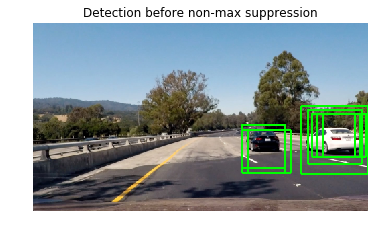

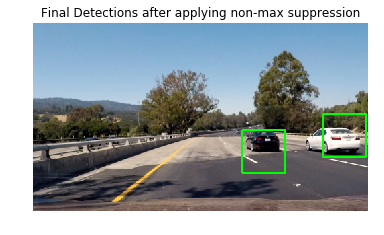

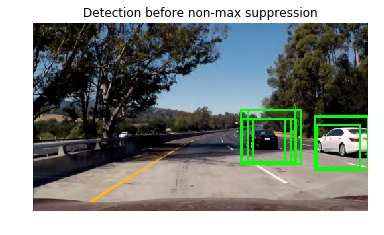

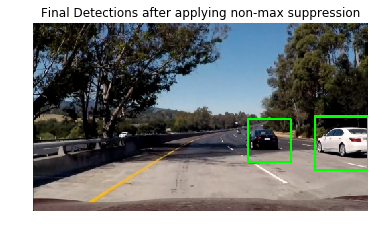

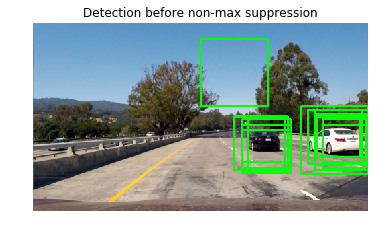

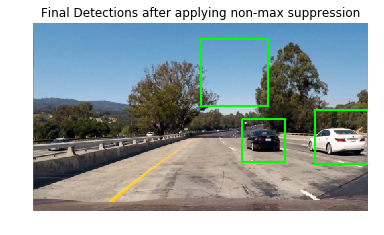

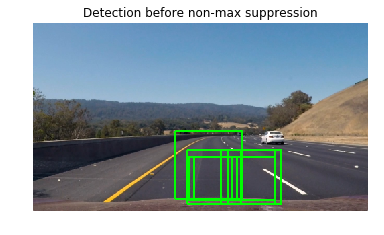

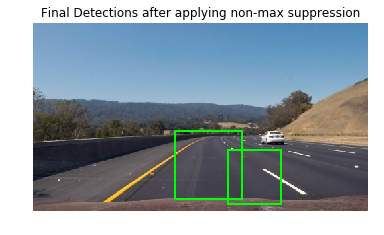

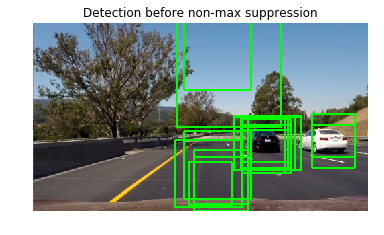

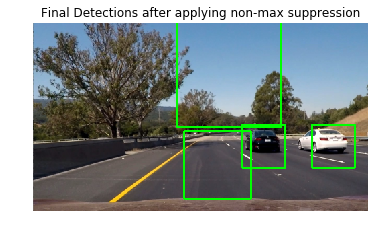

In [7]:
foldername = test_forder
test_folder(foldername)